# Airbnb San Francisco Data Analysis

## We will be analyzing Airbnb's trends in San Francisco. We will start off with basic analysis of popular trends and data visualization of such trends.

## Once we have some general idea of how the market breaks down in SF, we can use scikit learn and machine learning to predict prices based on several factors.

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import csv
from collections import Counter
import matplotlib.pyplot as plt
# module created by UC Berkeley students
from datascience import *
from mpl_toolkits.basemap import Basemap
import sklearn.metrics as metrics
from sklearn.grid_search import GridSearchCV
from sklearn.grid_search import RandomizedSearchCV
from sklearn import metrics
from sklearn import datasets
from sklearn import cross_validation
from sklearn import linear_model
from sklearn import ensemble
from IPython.core.display import HTML


# set the max rows into 15 for display
pd.set_option('display.height', 15)
pd.set_option('display.max_Rows', 15)

listings_file = 'listings.csv'

# import columns we want to extract
columns = ['price',
           'summary',
           'neighbourhood_cleansed',
           'property_type',
           'room_type',
           'price',
           'number_of_reviews',
           'instant_bookable',
           'review_scores_rating',
           'beds',
           'bedrooms',
           'bathrooms',
           'accommodates',
           'amenities',
           'cancellation_policy',
           'reviews_per_month',
           'latitude',
           'longitude']
listing = pd.read_csv(listings_file, usecols=columns)

# first 5 of the listing file
listing[0:5]

height has been deprecated.



summary neighbourhood_cleansed  \
0  Amazing views from this immense 3 bedroom/ 2 b...               Seacliff   
1  My two story house is located in the quite sid...               Seacliff   
2  Come relax in our 1 bedroom 1 bath house minut...               Seacliff   
3  Three-bedroom in exclusive Seacliff neighborho...               Seacliff   
4  Minutes to GG Bridge, GG Park, Museums, The Pr...               Seacliff   

    latitude   longitude property_type        room_type  accommodates  \
0  37.779685 -122.510472   Condominium  Entire home/apt             6   
1  37.780659 -122.505635         House     Private room             4   
2  37.781433 -122.505179         House  Entire home/apt             4   
3  37.787664 -122.489152         House  Entire home/apt             6   
4  37.782133 -122.492730     Apartment  Entire home/apt             6   

   bathrooms  bedrooms  beds  \
0        2.0         3     3   
1        1.0         1     2   
2        1.0         1     2   
3        2.5         3     4   
4        2.5         3     4   

                                           amenities    price  \
0  {TV,"Cable TV","Wireless Internet",Kitchen,Hea...  $400.00   
1  {TV,Internet,"Wireless Internet",Kitchen,Heati...   $99.00   
2  {TV,Kitchen,"Free Parking on Premises","Pets A...  $155.00   
3  {TV,Internet,"Wireless Internet",Kitchen,"Free...  $895.00   
4  {TV,Internet,"Wireless Internet",Kitchen,"Free...  $195.00   

   number_of_reviews  review_scores_rating instant_bookable  \
0                  3                    80                t   
1                 23                    91                f   
2                 45                    88                t   
3                  0                   NaN                f   
4                  4                   100                f   

  cancellation_policy  reviews_per_month  
0              strict               0.88  
1              strict               1.85  
2              strict               5.87  
3            flexible                NaN  
4              strict               2.45

### Cleaning up the data

In [3]:
# replacing NaN values with 0
listing.fillna(0, inplace=True)

# excluding listings with "0" for price, bedrooms, etc
listing = listing[listing.bedrooms > 0]
listing = listing[listing.beds > 0]
listing = listing[listing.review_scores_rating > 0]
listing = listing[listing.reviews_per_month > 0]
listing = listing[listing.accommodates > 0]
listing = listing[listing.bathrooms > 0]

### Let's creat a mapping of all the listings to visualize geographical clusters

In [4]:
# we only need latitude and longitude to determine the location
location = listing[['latitude', 'longitude']]

### Red will represent Entire home / apartments
### Blue will represent private rooms
### Green will represent shared rooms

In [257]:
plt.figure(figsize=(12,12))

# the longitude and latitude limits of San Francisco
map_extent = [-122.53, 37.68, -122.35, 37.833]
themap = Basemap(llcrnrlon=map_extent[0], 
                 llcrnrlat=map_extent[1],
                 urcrnrlon=map_extent[2], 
                 urcrnrlat=map_extent[3],
                 projection='gall',
                 resolution='f', epsg=4269)

# creating outlines for the basemap
themap.drawcoastlines()
themap.drawcountries()
themap.fillcontinents(color = 'gainsboro')
themap.drawmapboundary(fill_color='steelblue')

# splitting each type of property
home = listing[(listing.room_type == 'Entire home/apt')]
private = listing[(listing.room_type == 'Private room')]
shared = listing[(listing.room_type == 'Shared room')]

# then splitting them based on longitude and latitude
a, b = themap(home['longitude'], home['latitude'])
c, d = themap(private['longitude'], private['latitude'])
e, f = themap(shared['longitude'], shared['latitude'])

# plotting using different colors
themap.plot(a, b, 'o',                   
            color='Red',      
            markersize=4)
themap.plot(c, d, 'o',                   
            color='Green',       
            markersize=4)
themap.plot(e, f, 'o',                    
            color='Blue',         
            markersize=4)

### Let's count how many listings there are separated by neighborhoods

In [13]:
# using Counter to analyze frequency of each listing based on neighborhood
nh = Counter(listing['neighbourhood_cleansed'])

nh

Counter({'Bayview': 88,
         'Bernal Heights': 299,
         'Castro/Upper Market': 375,
         'Chinatown': 37,
         'Crocker Amazon': 18,
         'Diamond Heights': 12,
         'Downtown/Civic Center': 146,
         'Excelsior': 100,
         'Financial District': 62,
         'Glen Park': 58,
         'Golden Gate Park': 5,
         'Haight Ashbury': 313,
         'Inner Richmond': 192,
         'Inner Sunset': 103,
         'Lakeshore': 39,
         'Marina': 211,
         'Mission': 773,
         'Nob Hill': 188,
         'Noe Valley': 268,
         'North Beach': 113,
         'Ocean View': 78,
         'Outer Mission': 120,
         'Outer Richmond': 146,
         'Outer Sunset': 184,
         'Pacific Heights': 146,
         'Parkside': 107,
         'Potrero Hill': 195,
         'Presidio': 1,
         'Presidio Heights': 23,
         'Russian Hill': 133,
         'Seacliff': 11,
         'South of Market': 440,
         'Treasure Island/YBI': 4,
         'Twin Pea

###  Let's visualize the frequency of listings separated by neighborhood using a bar graph

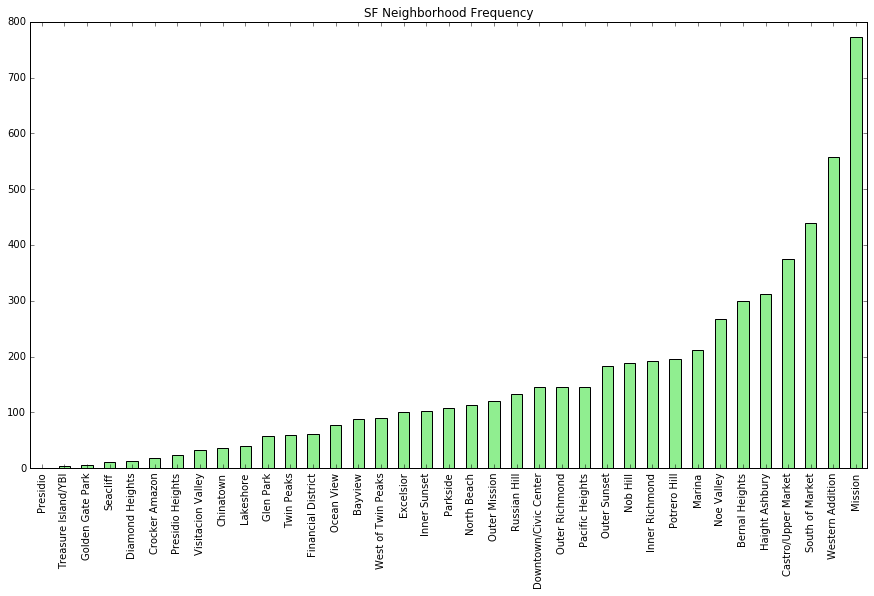

In [14]:
nh_df = pd.DataFrame.from_dict(nh, orient='index').sort_values(by=0)
nh_df.plot(kind='bar', 
           color = 'LightGreen', 
           figsize =(15,8), 
           title = 'SF Neighborhood Frequency', 
           legend = False)

It looks like Mission has the most listings, followed by Western Addition, South of Market, and Castro/Upper Market. We will now analyze the average listing on SF, then further break it down for each neighborhood to understand the pricing breakdown.

### Let's see the average price of every listing available on SF

In [15]:
# extract the 'prices' from the table
price = listing['price']
prices = []

# the values are stored as '$7,000' instead of 7000.
# data cleaning to make the values into floats
for element in price:
    element = float(element[1:].replace(',',''))
    prices.append(element)

# replacing the current column into a new one for future use
listing['price'] = prices
listing = listing[listing.price > 0]
average_price = sum(listing.price) / float(len(listing.price))
average_price

203.64361795006113

### Let's see what the average prices are for each neighborhood

In [16]:
# extracting the names
neighborhood_names = list(nh.keys())

# 2 column table of neighborhood names and prices
nh_prices = listing[['neighbourhood_cleansed', 'price']]
nh_prices.columns = ['neighbourhood', 'price']

# we pick out the rows which have neighborhood names with 400+ listings.
nh_prices = nh_prices[nh_prices['neighbourhood'].isin(neighborhood_names)]

# group by neighbourhood and then aggreate the prices based on mean
nh_prices_group = nh_prices.groupby('neighbourhood')
nh_prices = nh_prices_group['price'].agg(np.mean)

# turn dictionary's keys and values into a table for easy read
nh_prices = nh_prices.reset_index()
nh_prices['number of listings'] = nh.values()

nh_prices

neighbourhood       price  number of listings
0                 Bayview  139.863636                 184
1          Bernal Heights  183.073579                  60
2     Castro/Upper Market  246.754667                 146
3               Chinatown  181.270270                 268
4          Crocker Amazon  120.055556                 146
5         Diamond Heights  200.750000                   5
6   Downtown/Civic Center  192.705479                 773
..                    ...         ...                 ...
30               Seacliff  206.909091                  32
31        South of Market  193.034091                 299
32    Treasure Island/YBI  127.250000                 113
33             Twin Peaks  208.233333                 120
34      Visitacion Valley  118.250000                  11
35     West of Twin Peaks  187.522222                 440
36       Western Addition  210.109515                  12

[37 rows x 3 columns]

### Let's graph each neighborhood based on prices

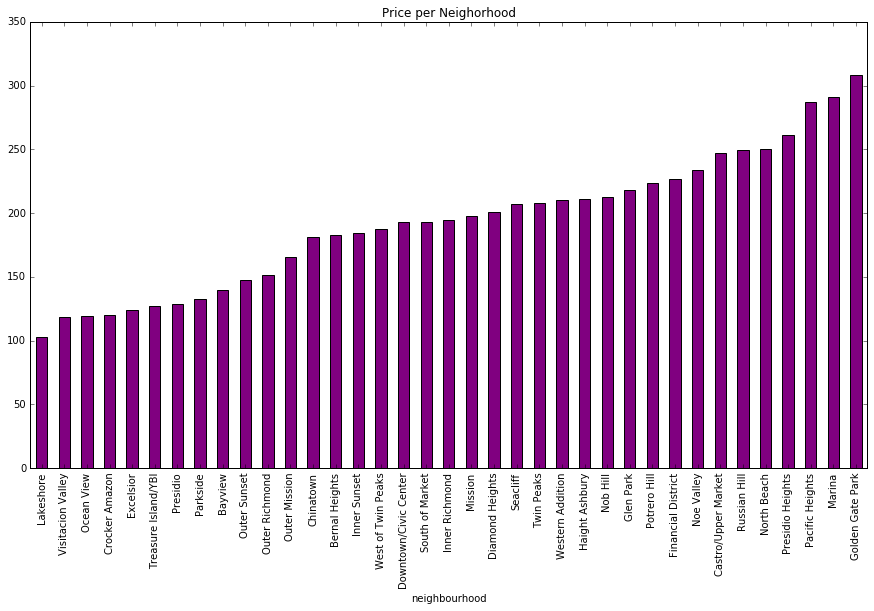

In [17]:
p = nh_prices.sort_values(by = 'price')
p.plot(x = "neighbourhood",
       y = "price",
       kind='bar', 
       color = 'Purple', 
       figsize =(15,8), 
       title = 'Price per Neighorhood', 
       legend = False)

By analyzing the number of listings and prices per neighborhood, we can get a clearer understanding of how accurate the average price is per neighborhood. The neighorhoods with a lot of listings (such as Russian Hill or Bayview), we can expect a more accurate average prices. However, neighborhoods with less than 100 listings might have relatively inaccurate average prices due to presence of outliers.

Our work isn't done here just yet. Looking at the analysis we did so far, one might conclude that certain neighborhoods are more 'expensive' than others. However, we have more metadata we can explore: the property types and room types. We can analyze these 2 columns to see if differences in prices are caused based on neighborhood, or by other factors. 

First, let's dive into see the percentage breakdown of property and room types of listings.

In [18]:
room = listing.room_type
r = Counter(room)

room_df = pd.DataFrame.from_dict(r, orient='index').sort_values(by=0)
room_df.columns = ['room_type']
room_df.plot.pie(y = 'room_type', 
                 colormap = 'summer', 
                 figsize=(8,8), 
                 fontsize = 20, autopct = '%.2f',
                 legend = False,
                 title = 'Room Type Distribution')

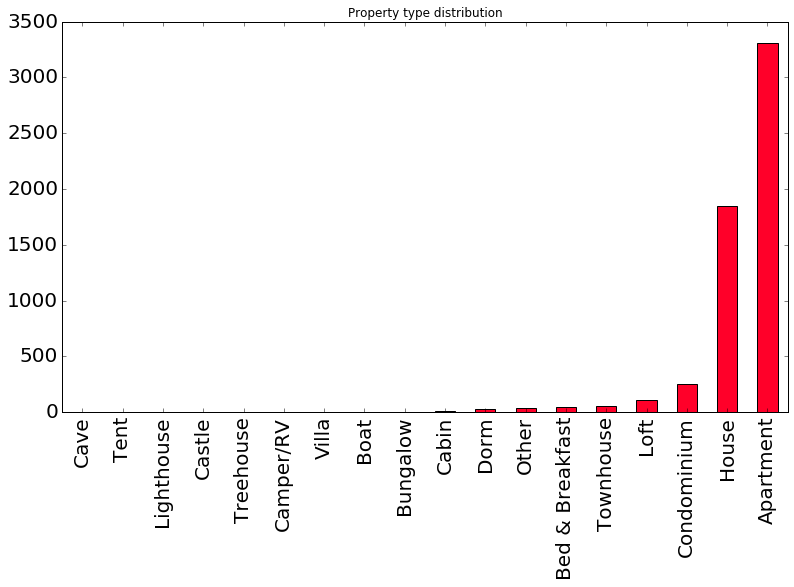

In [19]:
property = listing.property_type
p = Counter(property)

property_df = pd.DataFrame.from_dict(p, orient='index').sort_values(by=0)
property_df.columns = ['property_type']
property_df.plot.bar(y= 'property_type', 
                     colormap = 'gist_rainbow',
                     fontsize = 20,
                     legend = False,
                     figsize= (13, 7),
                     title = "Property type distribution")

It seems that people list their entire residency more than half the times, followed by private room. And not surprisingly, Apartment and houses take up an overwhelming majority of all listings, although we do see few instances unfamiliar residencies here and there. This tells us that we should keep our eye on the property and room types when predicting the prices of listings.

### Now let's break property and room type down by price.

In [20]:
prop_room = listing[['property_type', 'room_type', 'price']]

# first ten of the table
prop_room[0:10]

property_type        room_type  price
0    Condominium  Entire home/apt    400
1          House     Private room     99
2          House  Entire home/apt    155
4      Apartment  Entire home/apt    195
5      Apartment  Entire home/apt    395
6          House  Entire home/apt    150
9      Apartment  Entire home/apt    192
11     Apartment  Entire home/apt    325
12     Apartment     Private room     85
14         House  Entire home/apt    175

In [23]:
# Grouping by porperty and room type, and then aggregating them
# using mean of the price
prop_room_group = prop_room.groupby(['property_type', 'room_type']).mean()

# resetting the index in order to turn the lists into a readable table
p = prop_room_group.reset_index()

# pivoting the table based on the 3 factors, in order.
p = p.pivot('property_type', 'room_type', 'price')

# replacing the NaN values with 0
p.fillna(0.00, inplace=True)

p

room_type        Entire home/apt  Private room  Shared room
property_type                                              
Apartment             247.223976    120.041061    85.629310
Bed & Breakfast       148.333333    106.482759    46.250000
Boat                  196.800000      0.000000     0.000000
Bungalow              253.333333    101.500000     0.000000
Cabin                 194.200000    141.666667     0.000000
Camper/RV             260.000000    129.000000     0.000000
Castle                425.000000      0.000000     0.000000
...                          ...           ...          ...
Lighthouse            195.000000      0.000000     0.000000
Loft                  338.322034    139.969697    71.227273
Other                 234.615385    125.545455    75.000000
Tent                    0.000000     50.000000     0.000000
Townhouse             336.076923    115.000000    56.444444
Treehouse             261.500000      0.000000     0.000000
Villa                2000.000000    700.000000     0.000000

[18 rows x 3 columns]

This chart allows us to see all the listings' prices broken down by property type and room type. This gives us a much better understanding of the price breakdown in SF based on property and room types.

### Now that we've seen how property and room types along with neighborhood can affect the listing prices, let's investigate the summary.

In [24]:
summary = listing[['summary']]

# gets rid of NaN values with pandas' notnull function
summary = summary[pd.notnull(summary['summary'])]
summary

summary
0     Amazing views from this immense 3 bedroom/ 2 b...
1     My two story house is located in the quite sid...
2     Come relax in our 1 bedroom 1 bath house minut...
4     Minutes to GG Bridge, GG Park, Museums, The Pr...
5     Our family-friendly condo is located in San Fr...
6     Charming, private, peaceful hideaway 2 blocks ...
9                                                     0
...                                                 ...
8598  This comfortable studio is located just 2 bloc...
8600  Beautiful, spacious, light-filled Edwardian ho...
8602  Wonderful OCEANFRONT Views from your private B...
8603  1930s remodeled light and airy residential  Fr...
8604  Beach front large private Bedroom w/ private b...
8614  Great location on the water in sunny SOMA. Nex...
8616  Want to go for a run to the Golden Gate Bridge...

[5727 rows x 1 columns]

### Let's see what words come up the most when people describe their homes

In [25]:
words = []

# accessing each summary, then each word, and putting it into an empty list
for detail in summary['summary']:
    if detail != 0:
        for word in detail.split():
            words.append(word)

# turning the list into a counter (dictionary) for frequency, then into a pandas dataframe
words = Counter(words)
word_count = pd.DataFrame.from_dict(words, orient='index').sort_values(by=0)

# renaming the column
word_count.columns = ['summary']

# sorting it from highest to lowest
word_count = word_count.sort_values(by=['summary'], ascending=False)
word_count

summary
and              8615
the              7453
a                6055
to               5414
in               5272
of               4147
with             3510
...               ...
park(De             1
Classy              1
gritty,             1
bedroom/bath        1
Dominic’s.          1
beaten              1
offices,to          1

[16950 rows x 1 columns]

From this, we can tell that unique words like "walk", "heart", "access", "golden gate", "restaurant", "distance", "public", "street", "block" are very commonly used words when hosts are describing their homes.

This makes sense because people typically use Airbnb because they simply need a place to sleep. Primarily purpose of airbnb isn't to provide luxuary hotel suites, but convenient place to stay that's near the attractions for travelers and visitors. Hosts naturally understand such purpose and create their summaries bsaed on location and distance rather than the housing itself.

### the last element we have yet to analyze is the number of reviews.

We can loosely interpret number of reviews as times people have stayed in the said listing. Of course, this depends on when the listing appeared, how long it appeared for, and various other factors. But it could serve to be useful information to see correlation between price and number of reviews.

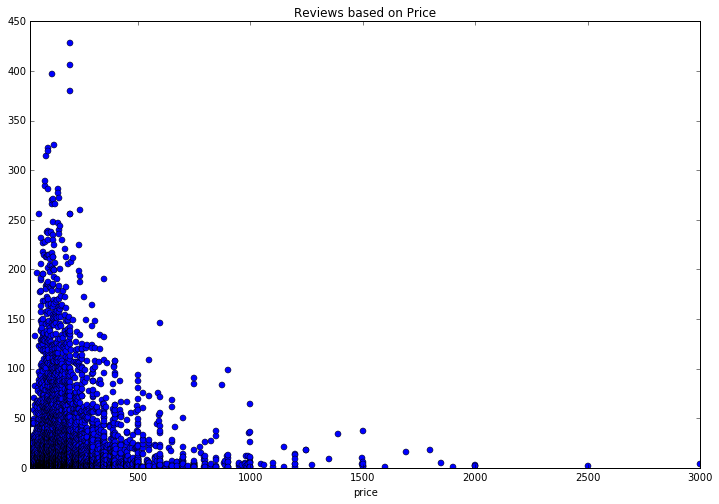

In [408]:
price_review = listing[['number_of_reviews', 'price']].sort_values(by = 'price')

price_review.plot(x = 'price', 
                  y = 'number_of_reviews', 
                  style = 'o',
                  figsize =(12,8),
                  legend = False,
                  title = 'Reviews based on Price')

The graph shows that listings with prices that range around 100 - 400 get the most reviews, probably because they are in the most reasonable price range. The number quickly declines as the price goes up.

This indicates that more people book listings that are around $100 - 400 in prices.

### Total number of reviews up to date

In [270]:
sum(listing.number_of_reviews)

152916

### Average number of reviews per listing

In [271]:
np.mean(listing.reviews_per_month)

1.6883813514929258

### Let's see how the cancellation policies on average are.

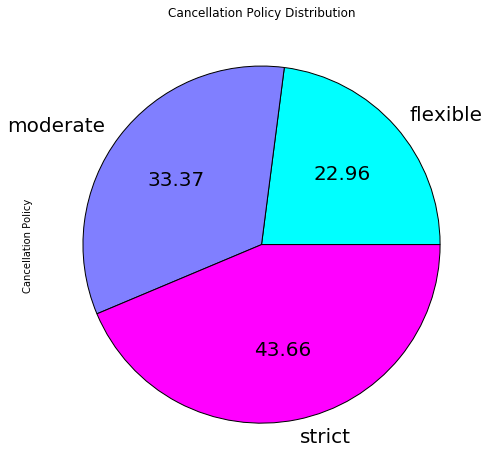

In [27]:
cancel = listing.cancellation_policy
c = Counter(cancel)

# cleaning up small values
c.pop("super_strict_30", None)
c.pop("super_strict_60", None)
cancel_df = pd.DataFrame.from_dict(c, orient='index').sort_values(by=0)
cancel_df.columns = ['Cancellation Policy']
cancel_df.plot.pie(y = 'Cancellation Policy',
                   colormap = 'cool',
                   figsize=(8,8), 
                   fontsize = 20, 
                   autopct = '%.2f',
                   legend = False,
                   title = "Cancellation Policy Distribution")

# Now that we've analyzed multiple aspects of the data set, let's combine all the import features we found and utilize scikit learn to predict prices

In [28]:
data = listing[['price',
           'room_type',
           'accommodates',
           'bathrooms',
           'bedrooms',
           'beds',
           'review_scores_rating',
           'instant_bookable',
           'cancellation_policy',
           'amenities']]

In [29]:
# cancellation policy and instant bookable factors are little bit more complicated.
# we use pandas get_dummies function to convert the categorical variable into indicator variables

cancel_policy = pd.get_dummies(data.cancellation_policy).astype(int)
instant_booking = pd.get_dummies(data.instant_bookable, prefix = 'instant_booking').astype(int)
room_type = pd.get_dummies(data.room_type).astype(int)

# ib has 2 columns, so we can just drop one of them.
instant_booking = instant_booking.drop('instant_booking_f', axis = 1)

In [30]:
# we drop the original columns and replace them with indicator columns
data = data.drop(['cancellation_policy', 'instant_bookable', 'room_type'], axis = 1)
data = pd.concat((data, cancel_policy, instant_booking, room_type), axis = 1)

In [31]:
# splitting the amenities list to draw out how many amenities each listing has

amenities_list = []

for element in data.amenities:
    element = element[1:]
    element = element[:-1]
    x = element.split()
    amenities_list.append(len(x))

data.amenities = amenities_list

In [32]:
data

price  accommodates  bathrooms  bedrooms  beds  review_scores_rating  \
0       400             6        2.0         3     3                    80   
1        99             4        1.0         1     2                    91   
2       155             4        1.0         1     2                    88   
4       195             6        2.5         3     4                   100   
5       395             6        2.5         3     4                   100   
6       150             2        1.0         1     1                    98   
9       192             4        1.0         1     3                    96   
...     ...           ...        ...       ...   ...                   ...   
8598    140             2        1.0         1     1                    95   
8600    125             2        1.0         1     1                    96   
8602    200             5        2.0         2     2                    80   
8603    889            13        3.0         4     7                    87   
8604    189             2        1.0         1     1                    96   
8614    199             2        1.0         2     2                   100   
8616    132             2        1.0         1     1                   100   

      amenities  flexible  moderate  strict  super_strict_30  super_strict_60  \
0            15         0         0       1                0                0   
1            16         0         0       1                0                0   
2             8         0         0       1                0                0   
4            16         0         0       1                0                0   
5            13         0         0       1                0                0   
6            22         1         0       0                0                0   
9            10         0         0       1                0                0   
...         ...       ...       ...     ...              ...              ...   
8598          8         0         0       1                0                0   
8600         24         0         0       1                0                0   
8602         12         0         0       1                0                0   
8603         18         0         0       1                0                0   
8604         27         0         1       0                0                0   
8614          7         0         1       0                0                0   
8616          3         1         0       0                0                0   

      instant_booking_t  Entire home/apt  Private room  Shared room  
0                     1                1             0            0  
1                     0                0             1            0  
2                     1                1             0            0  
4                     0                1             0            0  
5                     0                1             0            0  
6                     0                1             0            0  
9                     0                1             0            0  
...                 ...              ...           ...          ...  
8598                  0                1             0            0  
8600                  1                0             1            0  
8602                  1                1             0            0  
8603                  0                1             0            0  
8604                  1                0             1            0  
8614                  0                1             0            0  
8616                  0                1             0            0  

[5727 rows x 16 columns]

## Now that we converted all the varibles to numerical values, let's make our training and testing data sets.

Using scikit learn's train_test_split function, we can cross-validate the data set by partitioning it into training and testing data sets.

In [278]:
# splitting the training and test sets with a 60% and 40% size of original
split_data = data.drop(['price'], axis = 1)

train1, test1, train2, test2 = cross_validation.train_test_split(split_data,
                                                data.price, 
                                                test_size=0.4,
                                                train_size = 0.6,
                                                random_state=13)


### Let's see if a Linear Regression and Ridge models can predict the prices accurately

In [279]:
# mean of prices
mean = np.mean(data.price)

# standard deviation to compare 
std = np.std(data.price)

print("mean: " + str(mean))
print ("standard deviation: " + str(std))

mean: 203.64361795006113
standard deviation: 178.12320738157354


In [280]:
# linear regression testing
linear_reg = linear_model.LinearRegression()
linear_reg.fit(train1, train2)
linear_reg_error = metrics.median_absolute_error(test2, linear_reg.predict(test1))

# ridge model testing
ridge = linear_model.Ridge()
ridge.fit(train1, train2)
ridge_error = metrics.median_absolute_error(test2, ridge.predict(test1))
print ("Linear Regression: " + str(linear_reg_error))
print ("Ridge: " + str(ridge_error))

Linear Regression: 39.7421355635
Ridge: 39.8251493646


### It seems that both linear regression and ridge come out to be around $40 of error when predicting the prices. Let's see if we can lower this number by utilizing scikit learn's ensemble and GridSearchCV.

GridSearchCV is an exhausive search method over specified parameter values for an estimator.

Particularly, we want to focus on AdaBoostRegressor, GradientBoostRegressor, and BaggingRegressor for our estimators.

AdaBoostRegressor: meta-estimator that fits a regressor on the original dataset and then fits additional copies of the regressor utilizing different and adjusted weights of the errors.

GradientBoostingRegressor: estimator that allows for optimization of arbitrary differentiable loss functions, where in each stage a regression tree is fit on the negative gradient.

BaggingRegressor: it is an ensemble meta-estimator that fits base regressors each on random subsets of the original datasets and then aggregate their individual predictions to a final one. The benefit is that it reduces variance of black-box estimaor like a decision tree using randomization.

In [281]:
# ada boost regressor

param_names = ["n_estimators", "learning_rate", "loss"]
param_values = [[1], [1,2], ['linear']]

parameters = dict(zip(param_names, param_values))

abr = GridSearchCV(ensemble.AdaBoostRegressor(),
                   cv = 3,
                   param_grid = parameters,
                   scoring = 'median_absolute_error')
preds = abr.fit(train1, train2)
abr_best_estimator = abr.best_estimator_

In [282]:
# gradient boosting regressor

param_names = ["n_estimators", "max_depth", "learning_rate", "loss", "min_samples_split"]
param_values = [[100,300,500], [1,2,3,4], [0.01, 0.02], ['ls', 'lad'], [1,2]]

parameters = dict(zip(param_names, param_values))
gbr = GridSearchCV(ensemble.GradientBoostingRegressor(), 
                   cv = 3, 
                   param_grid = parameters, 
                   scoring='median_absolute_error')
preds = gbr.fit(train1, train2)
gbr_best_estimator = gbr.best_estimator_

In [283]:
# bagging regressor

param_names = ["n_estimators", "max_features", "bootstrap", "oob_score"]
param_values = [[100,500,1000], [1,5,10], [True, False], [False]]

parameters = dict(zip(param_names, param_values))
br = GridSearchCV(ensemble.BaggingRegressor(), 
                   cv = 3, 
                   param_grid = parameters, 
                   scoring='median_absolute_error')
preds = br.fit(train1, train2)
br_best_estimator = br.best_estimator_

In [284]:
print("AdaBoostRegressor: " + "$" + str(abs(abr.best_score_)))
print("GradientBoostingRegressor: " + "$" + str(abs(gbr.best_score_)))
print("BaggingRegressor: " + "$" + str(abs(br.best_score_)))

AdaBoostRegressor: $40.0896737969
GradientBoostingRegressor: $31.3053021005
BaggingRegressor: $39.0847106128


By using GridSearchCV, we can run different combinations of selected hyper-parameters. It seems that AdaBoostRegressor and BaggingRegressor (after some tuning) arrives at similar results as our previous linear and ridge regressors. 

Gradient Boosting Regressor, however, seems to do singificantly better (error decreased by 25%) than all the others. We can take a closer look at the gradient boosting regressor's characteristics:

In [290]:
gbr_best_estimator

GradientBoostingRegressor(alpha=0.9, init=None, learning_rate=0.02,
             loss='lad', max_depth=2, max_features=None,
             max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=1,
             min_weight_fraction_leaf=0.0, n_estimators=300,
             presort='auto', random_state=None, subsample=1.0, verbose=0,
             warm_start=False)

Let's now graph the features and their relevance based on importance.

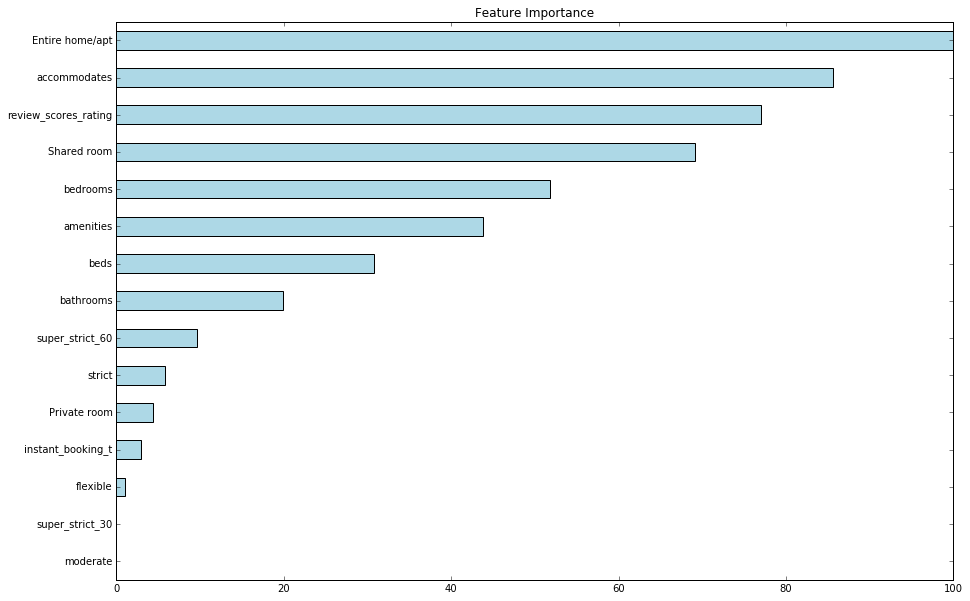

In [371]:
feature_importance = gbr_best_estimator.feature_importances_
feature_score = 100.0 * (feature_importance / feature_importance.max())

feature = pd.Series(feature_score, index = train1.columns).sort_values(ascending = True)

feature.plot(kind = 'barh',
              figsize = (15,10),
              color = 'LightBlue',
              title = 'Feature Importance')

# Conclusion

In this data analysis project, I analyzed some of the most popular trends given the Airbnb's data on listings in San Francisco.

Summarized findings:
- Most of the listings are clustered near the bart stations and center of the city
- Mission (773), Western Addition (557) and South of Market (440) at the top 3 neighborhoods with most listings
- Average price of all SF listings is `$`203.64.
- Prices very wildly based on property and room types.
- Golden Gate Park (`$`308), Marina (`$`290), Pacific Heights (`$`287) are the most expensive neighborhoods.
- Majority of listings are rented for their entirety, although private room is a close second. This is the most important factor when people choose where to stay.
- Accomodates is the second most important factor, meaning that most people who use Airbnb at SF travel in groups.
- Almost all of listings are apartment or houses, with few interesting ones like castle or caves mixed in.
- Most frequent words in summaries show that more hosts talk about the surrounding area rather than the listing itself.
- Listings with prices around `$`200 - 300 get the most reviews, meaning that they are booked most often.
- Cancellation policies are fairly spread out, but it doesn’t make a big difference for most people.